### Train DNN

In [1]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
#from sklearn.model_selection import StratifiedKFold, KFold
#from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, TensorDataset, DataLoader
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import torch.nn.functional as F
import sys
module_path = Path().resolve().parents[1] / "src" / "models"

# Append the directory to sys.path
sys.path.append(str(module_path))


from trainDNN import *
from explainDNN import *
from predictDNN import *

module_path = Path().resolve().parents[1] / "src" / "postprocessing"

# Append the directory to sys.path
sys.path.append(str(module_path))


from getModelPerformance import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Load features

In [2]:
feature_path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_CS_men"
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labels.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)


In [3]:
features.shape[1]

139

In [4]:
features

array([[1.65998594e+00, 4.28944611e-01, 7.02115777e-01, ...,
        1.00000000e+00, 0.00000000e+00, 1.00107761e-02],
       [2.02627650e+00, 1.21783493e+03, 5.38437123e+03, ...,
        1.00000000e+00, 0.00000000e+00, 9.99999978e-03],
       [2.02627650e+00, 1.21783493e+03, 5.38437123e+03, ...,
        1.00000000e+00, 0.00000000e+00, 9.99999978e-03],
       ...,
       [1.26698812e+00, 1.36908578e+00, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000007e-02],
       [1.26698812e+00, 1.36908578e+00, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000007e-02],
       [1.26698812e+00, 1.36908578e+00, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000007e-02]])

#### Define the neural network architecture

In [5]:
loss_fn = torch.nn.MSELoss()

In [6]:
class DNN(torch.nn.Module):
    def __init__(self, layer_width):
        super(DNN, self).__init__()

        self.do_prob = 0.2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(features.shape[1], layer_width[0]),
            torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], layer_width[1]),
            torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[2]),
            torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[3]),
            torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[4]),
            torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[5]),
            torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[6]),
            torch.nn.BatchNorm1d(layer_width[6]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),

        )

        self.decoder = torch.nn.Sequential(

            # torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[6], layer_width[5]),
            #torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[4]),
            #torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[3]),
            #torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[2]),
            #torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[1]),
            #torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[0]),
            #torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], features.shape[1])
        )

        self.supervised = torch.nn.Sequential(
            torch.nn.Linear(layer_width[6], layer_width[7]),
            torch.nn.BatchNorm1d(layer_width[7]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[7], layer_width[8]),
            torch.nn.BatchNorm1d(layer_width[8]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[8], layer_width[9]),
            torch.nn.BatchNorm1d(layer_width[9]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[9], 1),

        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        targets = self.supervised(encoded)
        #return decoded, targets
        return targets
        
def initialize_weights(m):

    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)



In [7]:

layer_widths = [512, 512, 512, 512, 512, 512, 512, 512, 512, 512]  # Define your desired layer widthsmodel = DNN(layer_widths)#DNN(input_dim, layer_widths)
model = DNN(layer_widths)#DNN(input_dim, layer_widths)
model.apply(initialize_weights)
model.double()


DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [8]:
model = DNN(layer_widths)
model = model.double()
model.apply(initialize_weights)

torch.manual_seed(42)

In [9]:
#time intensive operation(better save processed features and labels, after first run)
features, labels = preprocess_features_labels(features, labels, X_mean, X_std) 
np.save("preprocessed/features_CS", features)
np.save("preprocessed/labels_CS", labels)

Duplicate row with index [1246 1247 1248] was in group 6 and was replaced with NaN values
Duplicate row with index [ 861 4326 4327] was in group 14 and was replaced with NaN values
Duplicate row with index [6525 6526 6529 6530 6531 6532] was in group 24 and was replaced with NaN values
Duplicate row with index [5579 5580 5581 5582 8625 8626 8627 8628 8629 8630 8631 8632 8633 8634
 8635 8636] was in group 45 and was replaced with NaN values
Duplicate row with index [6527 6528 6533 6534 6535 6536] was in group 96 and was replaced with NaN values
Duplicate row with index [8637 8638 8639 8640 8641 8642] was in group 117 and was replaced with NaN values
Duplicate row with index [665 666] was in group 129 and was replaced with NaN values
Duplicate row with index [ 855 4314] was in group 181 and was replaced with NaN values
Duplicate row with index [5360 5361 5597 5598 5599 5600 8563 8564] was in group 211 and was replaced with NaN values
Duplicate row with index [37358 37359 37360 37689 3769

In [10]:
features = np.load("preprocessed/features_CS.npy")
labels = np.load("preprocessed/labels_CS.npy")

In [11]:
features.shape

(14956, 139)

In [12]:
features = torch.tensor(features)
labels = torch.tensor(labels)

In [13]:
trainloader, testloader = create_train_test_loader(features, labels, batch_size = 200, test_size_ratio=1/7, shuffle=True)

Train data size
12820
Test data size
2136


In [14]:
"""
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
"""

'\nprint(f"Model structure: {model}\n\n")\n\nfor name, param in model.named_parameters():\n    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")\n'

In [15]:
# if there is a pretrained model, this can be used
"""
path = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_CS.pth"
state_dict = torch.load(path)
model.load_state_dict(state_dict)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else 
#print(physical_devices)
model.to(device)
model.double()
"""

"\npath = '/gxfs_work/cau/sunms498/work/nn-toc/models/supervisedmodel_TOC_noconstraint_CS.pth'\nstate_dict = torch.load(path)\nmodel.load_state_dict(state_dict)\ndevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else \n#print(physical_devices)\nmodel.to(device)\nmodel.double()\n"

In [16]:
# GPU intensive operation!!
num_epochs = 500
training_accuracy, training_losses, training_mae, learning_rate, evaluation_losses, evaluation_mae, true_labels, pred_labels =  train_model(model, loss_fn, trainloader, testloader, num_epochs = num_epochs)

epoch: 0 | Training Loss: 1.840 | MAE: 0.522 | LR: 0.0100000 |
epoch: 0 | Testing Loss: 0.518 | MAE: 0.310  |

epoch: 1 | Training Loss: 0.688 | MAE: 0.361 | LR: 0.0100000 |
epoch: 1 | Testing Loss: 0.637 | MAE: 0.335  |

epoch: 2 | Training Loss: 0.669 | MAE: 0.353 | LR: 0.0064000 |
epoch: 2 | Testing Loss: 0.481 | MAE: 0.283  |

epoch: 3 | Training Loss: 0.669 | MAE: 0.325 | LR: 0.0064000 |
epoch: 3 | Testing Loss: 0.480 | MAE: 0.280  |

epoch: 4 | Training Loss: 0.589 | MAE: 0.318 | LR: 0.0040960 |
epoch: 4 | Testing Loss: 0.465 | MAE: 0.263  |

epoch: 5 | Training Loss: 0.562 | MAE: 0.304 | LR: 0.0032768 |
epoch: 5 | Testing Loss: 0.430 | MAE: 0.261  |

epoch: 6 | Training Loss: 0.553 | MAE: 0.304 | LR: 0.0026214 |
epoch: 6 | Testing Loss: 0.512 | MAE: 0.287  |

epoch: 7 | Training Loss: 0.512 | MAE: 0.296 | LR: 0.0020972 |
epoch: 7 | Testing Loss: 0.409 | MAE: 0.251  |

epoch: 8 | Training Loss: 0.526 | MAE: 0.294 | LR: 0.0020972 |
epoch: 8 | Testing Loss: 0.427 | MAE: 0.265  |

e

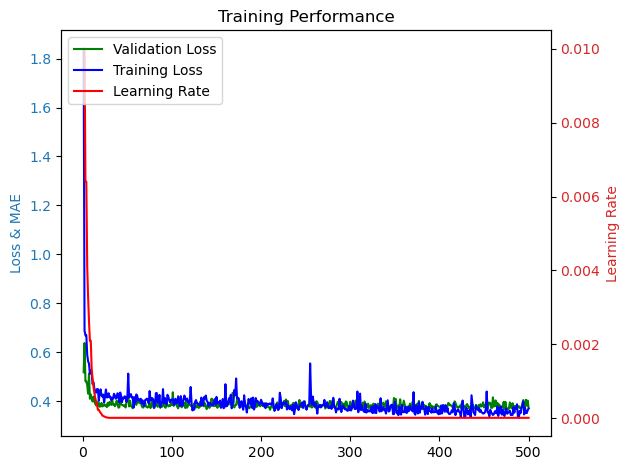

In [17]:
torch.manual_seed(42)
plot_model_performance(num_epochs, evaluation_losses, training_losses, learning_rate)

In [ ]:
output_path = Path().resolve().parents[1] / "data" / "output" / "scatterplots_TOC" / "scatter_plot_TOC_noconstraint_supervised_CS_men_test.png"
test_labels, test_targets = evaluate_model(model, testloader, output_path)

In [19]:
#lats = np.load("lats_CS.npy")
#lons = np.load("lons_CS.npy")
all_labels, all_targets =  evaluate_all_predictions(model, features, labels, output_path)


correlation coefficient:
0.8931853256148813
mae:
0.20741022965145656
mse:
0.2995256388039766
rmse:
0.547289355646514


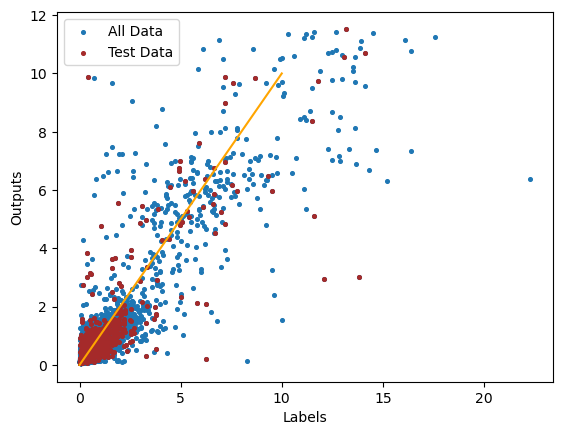

In [20]:
# Scatter plot with different colors for test labels and test targets
plt.scatter(all_labels, all_targets, label='All Data', s= 7)
plt.scatter(test_labels, test_targets, label='Test Data', color='brown', s=7)  # Add this line

line = np.linspace(0, 10, 100)

# Plot the reference line
plt.plot(line, line, 'orange')

# Set labels and title
plt.xlabel("Labels")
plt.ylabel("Outputs")

# Add legend
plt.legend()

In [21]:
torch.save(model.state_dict(), path = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_CS.pth")

In [22]:
"""
np.save("all_labels_NN_CS", all_labels)
np.save("all_predictions_NN_CS", all_targets)
np.save("test_labels_NN_CS", test_labels)
np.save("test_predictions_NN_CS", test_targets)
"""

'\nnp.save("all_labels_NN_CS", all_labels)\nnp.save("all_predictions_NN_CS", all_targets)\nnp.save("test_labels_NN_CS", test_labels)\nnp.save("test_predictions_NN_CS", test_targets)\n'

### Explain DNN using SHAP values (Find feature importance)

In [24]:

#should shuffle the indices again
features = np.load("preprocessed/features_CS.npy")
labels = np.load("preprocessed/labels_CS.npy")

import shap
import pandas as pd

# Convert the input features to a PyTorch tensor with the correct data type
features = torch.tensor(features, dtype=torch.float64)

if torch.cuda.is_available():
    features = features.cuda()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


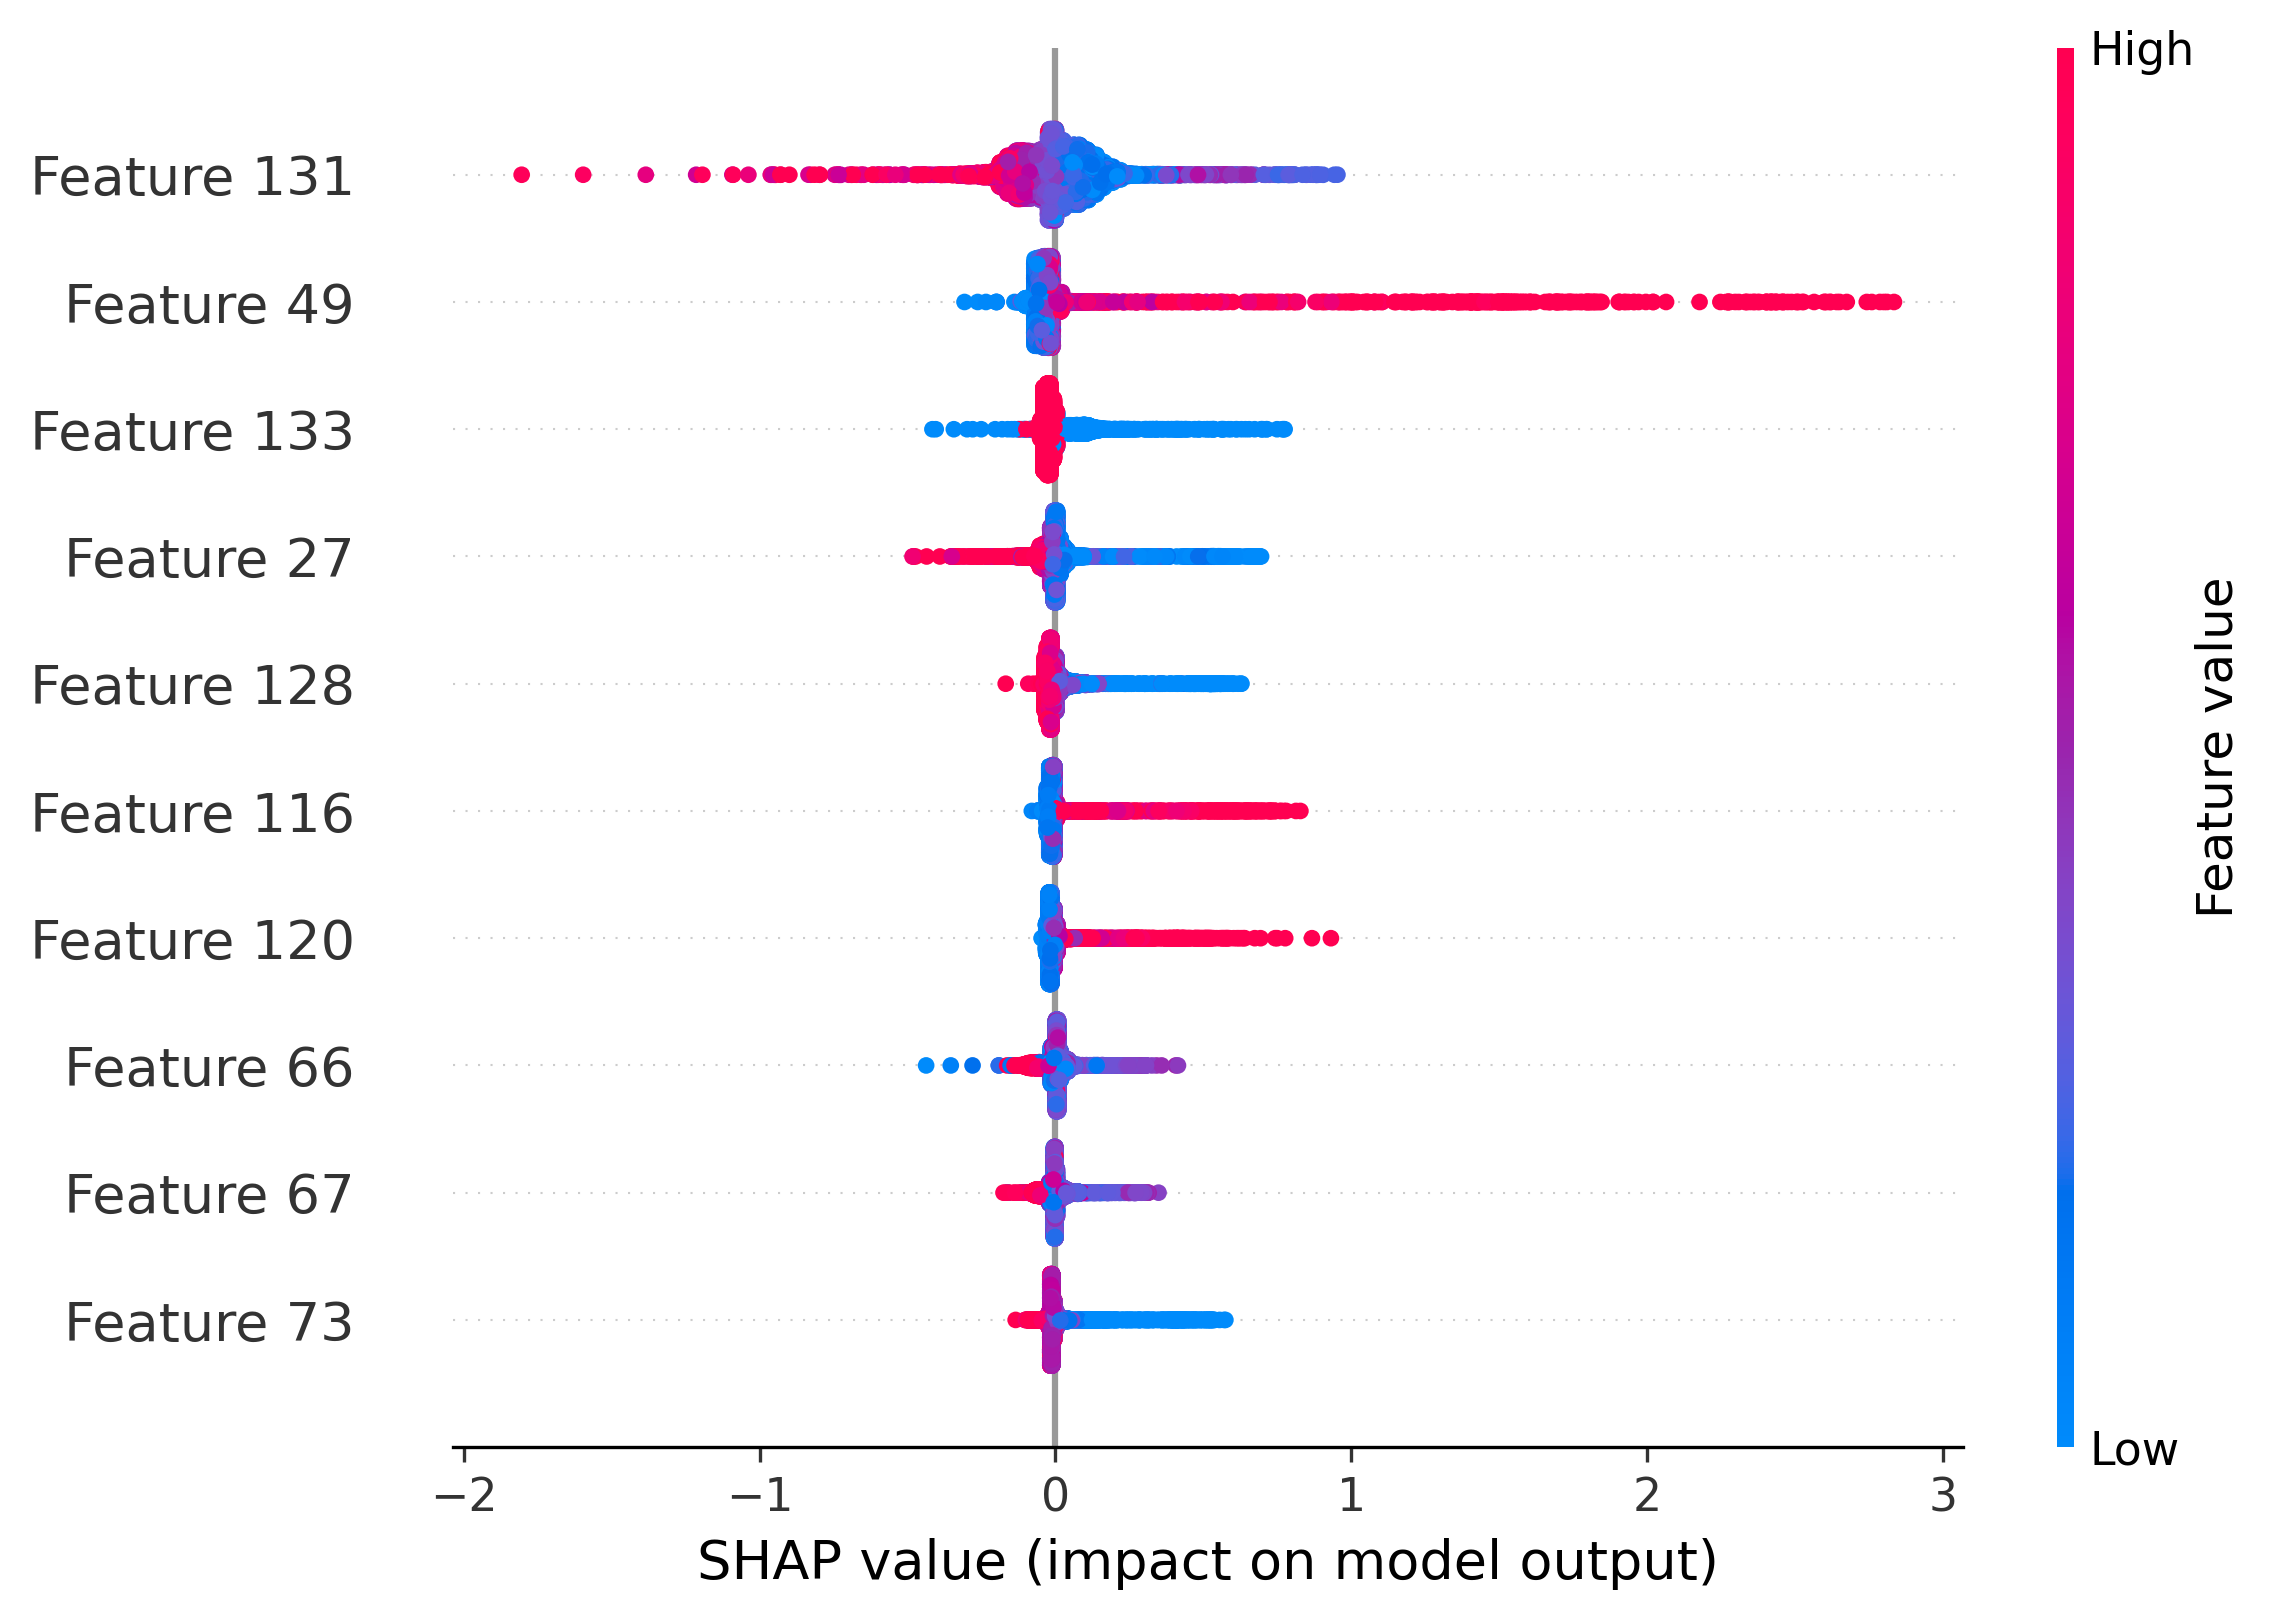

In [25]:
# GPU intensive operation!!!
explain_shap(model, features, feature_names=None, explainer_path='preprocessed/explainer_CS.pkl', shap_values_path='preprocessed/shap_values_CS.pkl', force_plot_index=0, summary_max_display=10)

#if the previous line has already been performed and the shap values are saved, only the following lines can be used.
with open('preprocessed/explainer_CS.pkl', 'rb') as explainer_file:
    explainer = pickle.load(explainer_file)

with open('preprocessed/shap_values_CS.pkl', 'rb') as shap_values_file:
    shap_values = pickle.load(shap_values_file)

### Predict using the trained DNN

In [5]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os
import gc
from os import walk  


feature_path = path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_CS_men"
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)

dataset_path = Path().resolve().parents[1] / "data" / "interim" / "worldfeatures" / "WorldFeaturesAllnoNaN_SedTOC"

files = []

for (dirpath, dirnames, filenames) in walk(dataset_path):
    files.extend(filenames)
    break

files.sort()


features = np.load(Path(dataset_path / files[0]))
prediction_sum_save = Path().resolve().parents[1] / "data" / "interim" / "predictions" / "predictions_CS"

In [34]:


model.eval()
enable_dropout(model) #for mc dropout


np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else 
#print(physical_devices)
model.to(device)
model.double()


In [35]:
features = np.load(Path(dataset_path / files[0]))

chunk_shape = [6,4320] #360 chunks


first_run = True
ii = 0

for count, file in enumerate(files):
    #if count > 2:
    #    break
    features = np.load(Path(dataset_path / file))
    features = np.divide((features - X_mean), X_std)

    features = torch.tensor(features)
    features = features.to(device)

    # Perform multiple forward passes with dropout
    num_samples = 100  # number of monte carlo forward passes: gives us the number of predictions or the size of the prediction ensemble
    predictions_sum = np.zeros((num_samples, chunk_shape[0], chunk_shape[1]))

    with torch.no_grad():
        for i in range(num_samples):
            predictions = model(features)
         
            # Store predictions for later averaging
            predictions_sum[i] = predictions.cpu().detach().numpy().reshape(chunk_shape)

    # Average predictions over all samples
    predictions_avg = np.mean(predictions_sum, axis=0)
    predictions_var = np.var(predictions_sum, axis=0)
    save_path = os.path.join(prediction_sum_save , f'predictions_sum_{ii}.npy')
    np.save(save_path, predictions_sum)
    #fit_params, failed_fits, failed_fit_details = fit_gaussian_to_predictions(predictions_sum)
    #print(failed_fits)

    if first_run:
        prediction_map2 = predictions_avg
        prediction_map2_var = predictions_var
        first_run = False
    else:
        prediction_map2 = np.append(prediction_map2, predictions_avg, axis=0)
        prediction_map2_var = np.append(prediction_map2_var, predictions_var, axis=0)

    ii += 1
    print("Prediction " + str(ii) + " done!")

    del features
    gc.collect()
    


Prediction 1 done!
Prediction 2 done!
Prediction 3 done!
Prediction 4 done!
Prediction 5 done!
Prediction 6 done!
Prediction 7 done!
Prediction 8 done!
Prediction 9 done!
Prediction 10 done!
Prediction 11 done!
Prediction 12 done!
Prediction 13 done!
Prediction 14 done!
Prediction 15 done!
Prediction 16 done!
Prediction 17 done!
Prediction 18 done!
Prediction 19 done!
Prediction 20 done!
Prediction 21 done!
Prediction 22 done!
Prediction 23 done!
Prediction 24 done!
Prediction 25 done!
Prediction 26 done!
Prediction 27 done!
Prediction 28 done!
Prediction 29 done!
Prediction 30 done!
Prediction 31 done!
Prediction 32 done!
Prediction 33 done!
Prediction 34 done!
Prediction 35 done!
Prediction 36 done!
Prediction 37 done!
Prediction 38 done!
Prediction 39 done!
Prediction 40 done!
Prediction 41 done!
Prediction 42 done!
Prediction 43 done!
Prediction 44 done!
Prediction 45 done!
Prediction 46 done!
Prediction 47 done!
Prediction 48 done!
Prediction 49 done!
Prediction 50 done!
Predictio

In [22]:
### GPU intensive operation!!
#prediction_map2, prediction_map2_var = perform_mc_dropout_prediction(model, dataset_path, prediction_sum_save, X_mean, X_std)

In [6]:
# We save the distributions or the monte carlo output for each chunk. Here we read all the distributions from different chunks and paste it together.
# Reading the distributions of all the chunks requires a lot of memory!!
# Requires high memory(RAM)(atleast 65 GB of RAM). Should probably be run on a CPU(prefereable a cluster) to get all the prediction distributions.
# UNCOMMENT IT TO PUT THE CHUNKS OF THE DISTRIBUTIONS TOGETHER
"""
import os
import numpy as np

# Get a list of files in the directory and sort them
files_in_dir = sorted([f for f in os.listdir(prediction_sum_save) if f.endswith('.npy')], key=lambda x: int(x.split('_')[-1][:-4]))


failed_fits_all = []
i = 0
first_run = True

# Load and concatenate each predictions_sum array along the second axis
for file in files_in_dir:
    file_path = os.path.join(prediction_sum_save, file)
    predictions_sum = np.load(file_path)
    
    if first_run:
        prediction_map_dist = predictions_sum
        first_run = False
    else:
        # Concatenate along the second axis (axis=1)
        prediction_map_dist = np.concatenate((prediction_map_dist, predictions_sum), axis=1)
    i += 1
    print(i)
np.save(Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_dist_CS", prediction_map_dist)
"""

In [36]:
land_file = path = Path().resolve().parents[1] / "data" / "raw" / "island_map.npy"
land_map = np.load(land_file)
land_map[np.isnan(land_map)] = 1


In [37]:
import matplotlib.colors as mcolors
prediction_map2 = np.rot90(np.rot90(np.fliplr(prediction_map2)))
#prediction_map2[land_map] = 0

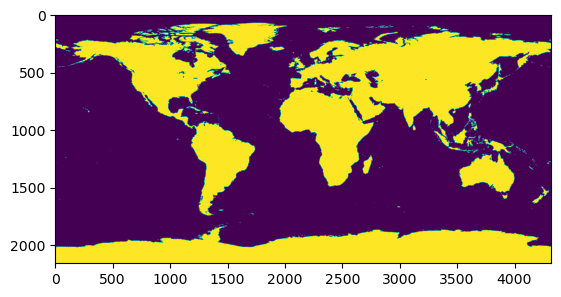

In [39]:
plt.imshow(land_map)

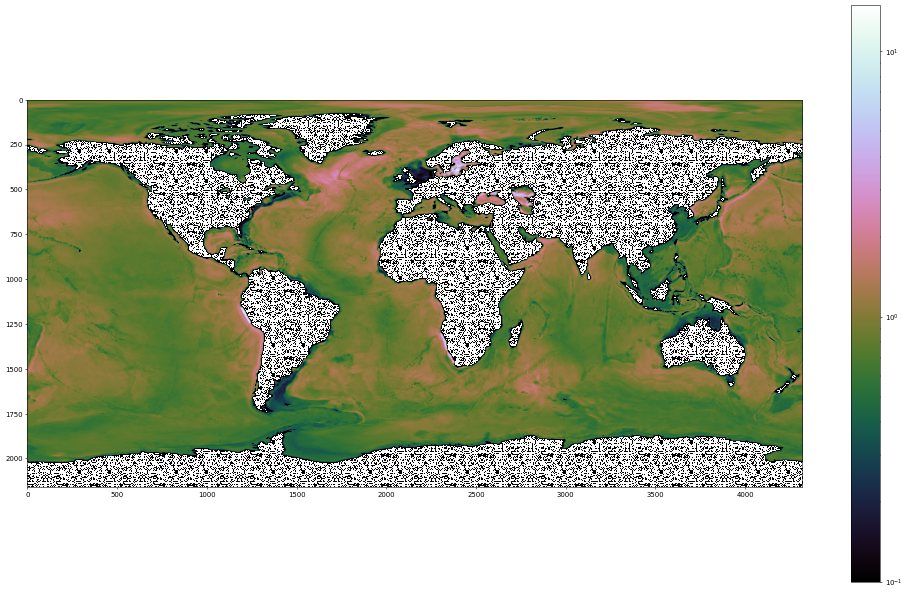

In [40]:
prediction_map2[land_map] = 0
plt.figure(figsize=[25, 15], dpi=50)
plt.imshow(prediction_map2, norm=mcolors.LogNorm(vmin=1e-1, vmax=15),cmap="cubehelix")
cbar = plt.colorbar()

In [41]:
np.save( Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_TOC_supervised_men_CS_noconstraint.npy", prediction_map2)